# TorchSDE + Neuromancer: Moving from Neural ODEs to Neural SDEs and Motivating the Latent SDE Architecture

This notebook goes over how to utilize torchsde's functionality within Neuromancer framework. This notebook is based off: https://github.com/google-research/torchsde/blob/master/examples/latent_sde_lorenz.py. In this example, we generate data according to a 3-dimensional stochastic Lorenz attractor. We then perform a "system identification" on this data -- seek to model a stochastic differential equation on this data. Upon performant training, this LatentSDE will then be able to reproduce samples that exhibit the same behavior as the provided Lorenz system. We train and utilize the Lightning framework to support custom functionality within the training loop.




### From Neural ODEs to Neural SDEs

#### 1. Neural ODEs

The general form of an ordinary differential equation (ODE) is:

$$ \frac{{dx}}{{dt}} = f(t, x) $$

Neural ODEs parameterize the evolution of the system, in continuous-time, in terms of a neural network: $ \frac{{dx}}{{dt}}  = f_{\theta}(x_k)$ where $\theta$ are network weights


Next we need to solve the continuous-time NODE model with suitable ODE solver, e.g., [Runge–Kutta integrator](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods).  

$$ x_{k+1} = \text{ODESolve}(f_{\theta}(x_k)) $$




For training we need to obtain accurate reverse-mode gradients of the integrated NODE system. This can be done in two ways, either by unrolling the operations of the ODE solver and using the [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time) (BPTT) algorithm, or via [Adjoint state method](https://en.wikipedia.org/wiki/Adjoint_state_method). Assuming we have a suitable ODE solver (integrator) then we can train $f_{\theta}(x_k)$ using our standard reference tracking loss (MSE) between predicted and ground-truth trajectory as they unroll.


Neuromancer provides a set of ODE solvers implemented in [integrators.py](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/dynamics/integrators.py).
For adjoint method we provide the interface to the [open-source implementation](https://github.com/rtqichen/torchdiffeq) via DiffEqIntegrator class.

#### 2. Latent ODEs

We can reformulate the above reference-tracking method for training Neural ODEs via a generative / variational inference approach. That is 
$$ z_{t_0} ∼ p(z_{t_0}) $$

$$ z_{t_1}, z_{t_2}, ..., z_{t_N} = ODESolve(z_{t_0}, f, θ_f, t_0, ..., t_N) $$

where each $$ x_{t_i} ∼ p(x|z_{t_i}, θ_x) $$

In this way the evolution of the latent states follow an ordinary differential equation and we observe observations emitted from the latent system dynamics. Since we never actually observe the "point estimates" of $z$ we have to integrate over $z$ to learn p(x), which can be done by treating this as a standard variational autoencoder network and training thusly.

#### 3. Neural ODEs with Added Stochasticicity

Stochastic differential equations are an extension of ordinary differential equations in that they are ODEs with instantaneous noise dynamics added to their determinisitic system dynamics. We denote the former as the diffusion process; the latter the drift process. They are often used to model phenomena governed by many small and unobserved interactions in chemistry and microbiology such as molecular motion in liquid; allele frequencies in genetics. They are also known to model price fluctations in financial markets for short-medium time horizons. 

The general form of a stochastic differential equation is, in differential form:

$$ dx = f(t, x) \, dt + g(t, x) \, dW $$

Where $W$ denotes a Weiner process (e.g. Brownian motion). We can see that if $g()$ is zero then the SDE simplifies to an ODE. Thus for training SDEs, we need an equivalent BPTT or adjoint state method to compute tractable and scalable gradients. Li, et al recently developed such an analogous backpropagation algorithm in https://arxiv.org/pdf/2001.01328. In our codebase we leverage such SDE solvers via the torchSDE library (https://github.com/google-research/torchsde/tree/master/torchsde). For reference, the main reason we can use numerical solvers for this stochastic calculus case is that the above differential equation's dynamics can be interepreted as: 

$$ X_{t+\Delta t} \approx \text{ODESolve}\left(X_t, f(\cdot) + g(\cdot) \frac{\Delta W}{\Delta t}, [t, t+\Delta t]\right) $$

(See the Euler-Murayama method)


 Given that these solvers exist, we now move on to the question of **training these non-deterministic dynamics. What loss do we optimize**? 

Fitting an SDE in the same vein as an ODE (e.g. via maximal likelihood -- our reference tracking (MSE) loss since we assume Gaussian distribution) **will not work**: it will overfit and send the diffusion term to zero. Thus the inclusion of the diffusion term into our differential equation is a roadblock formulating the SDE in a rollout-based manner as we do with Neural ODEs. Devising loss functions to support rollout and physical constraints on the system is an open research question. 

#### 4. Latent SDEs

It is natural to view training a Neural SDE from a probabilistic perspective: given training samples from a stochastic process, we wish to devise neural network(s) parameterizing the drift and diffusion terms (and perhaps other terms as well as shown below) that has the ability generate new data samples governed by the (learned) stochastic process. Thus we can employ the variational autoencoder approach similar to latent ODEs, but now the evolution of the latent states is modeled by an SDE and not an ODE. Other approaches exist as well, such as treating the SDE as Generative Adversarial Network (GAN). We only show the variational autoencoder form here.







______

## 0. Imports


In [ ]:
import torch
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import torch
import tqdm
from neuromancer.psl import plot
from neuromancer import psl
import torchsde
import torchsde

from torch.utils.data import DataLoader
from neuromancer.system import Node
from neuromancer.dynamics import integrators, ode
from neuromancer.trainer import Trainer, LitTrainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.psl import plot
from neuromancer import psl

from torch import nn
from torch import optim
from torch.distributions import Normal
from typing import Sequence

torch.manual_seed(0)


## 1. Neural ODE

To motivate this walkthrough, we first construct a Neural ODE to solve a (deterministic) Lotka-Volterra System

<Figure size 500x100 with 0 Axes>

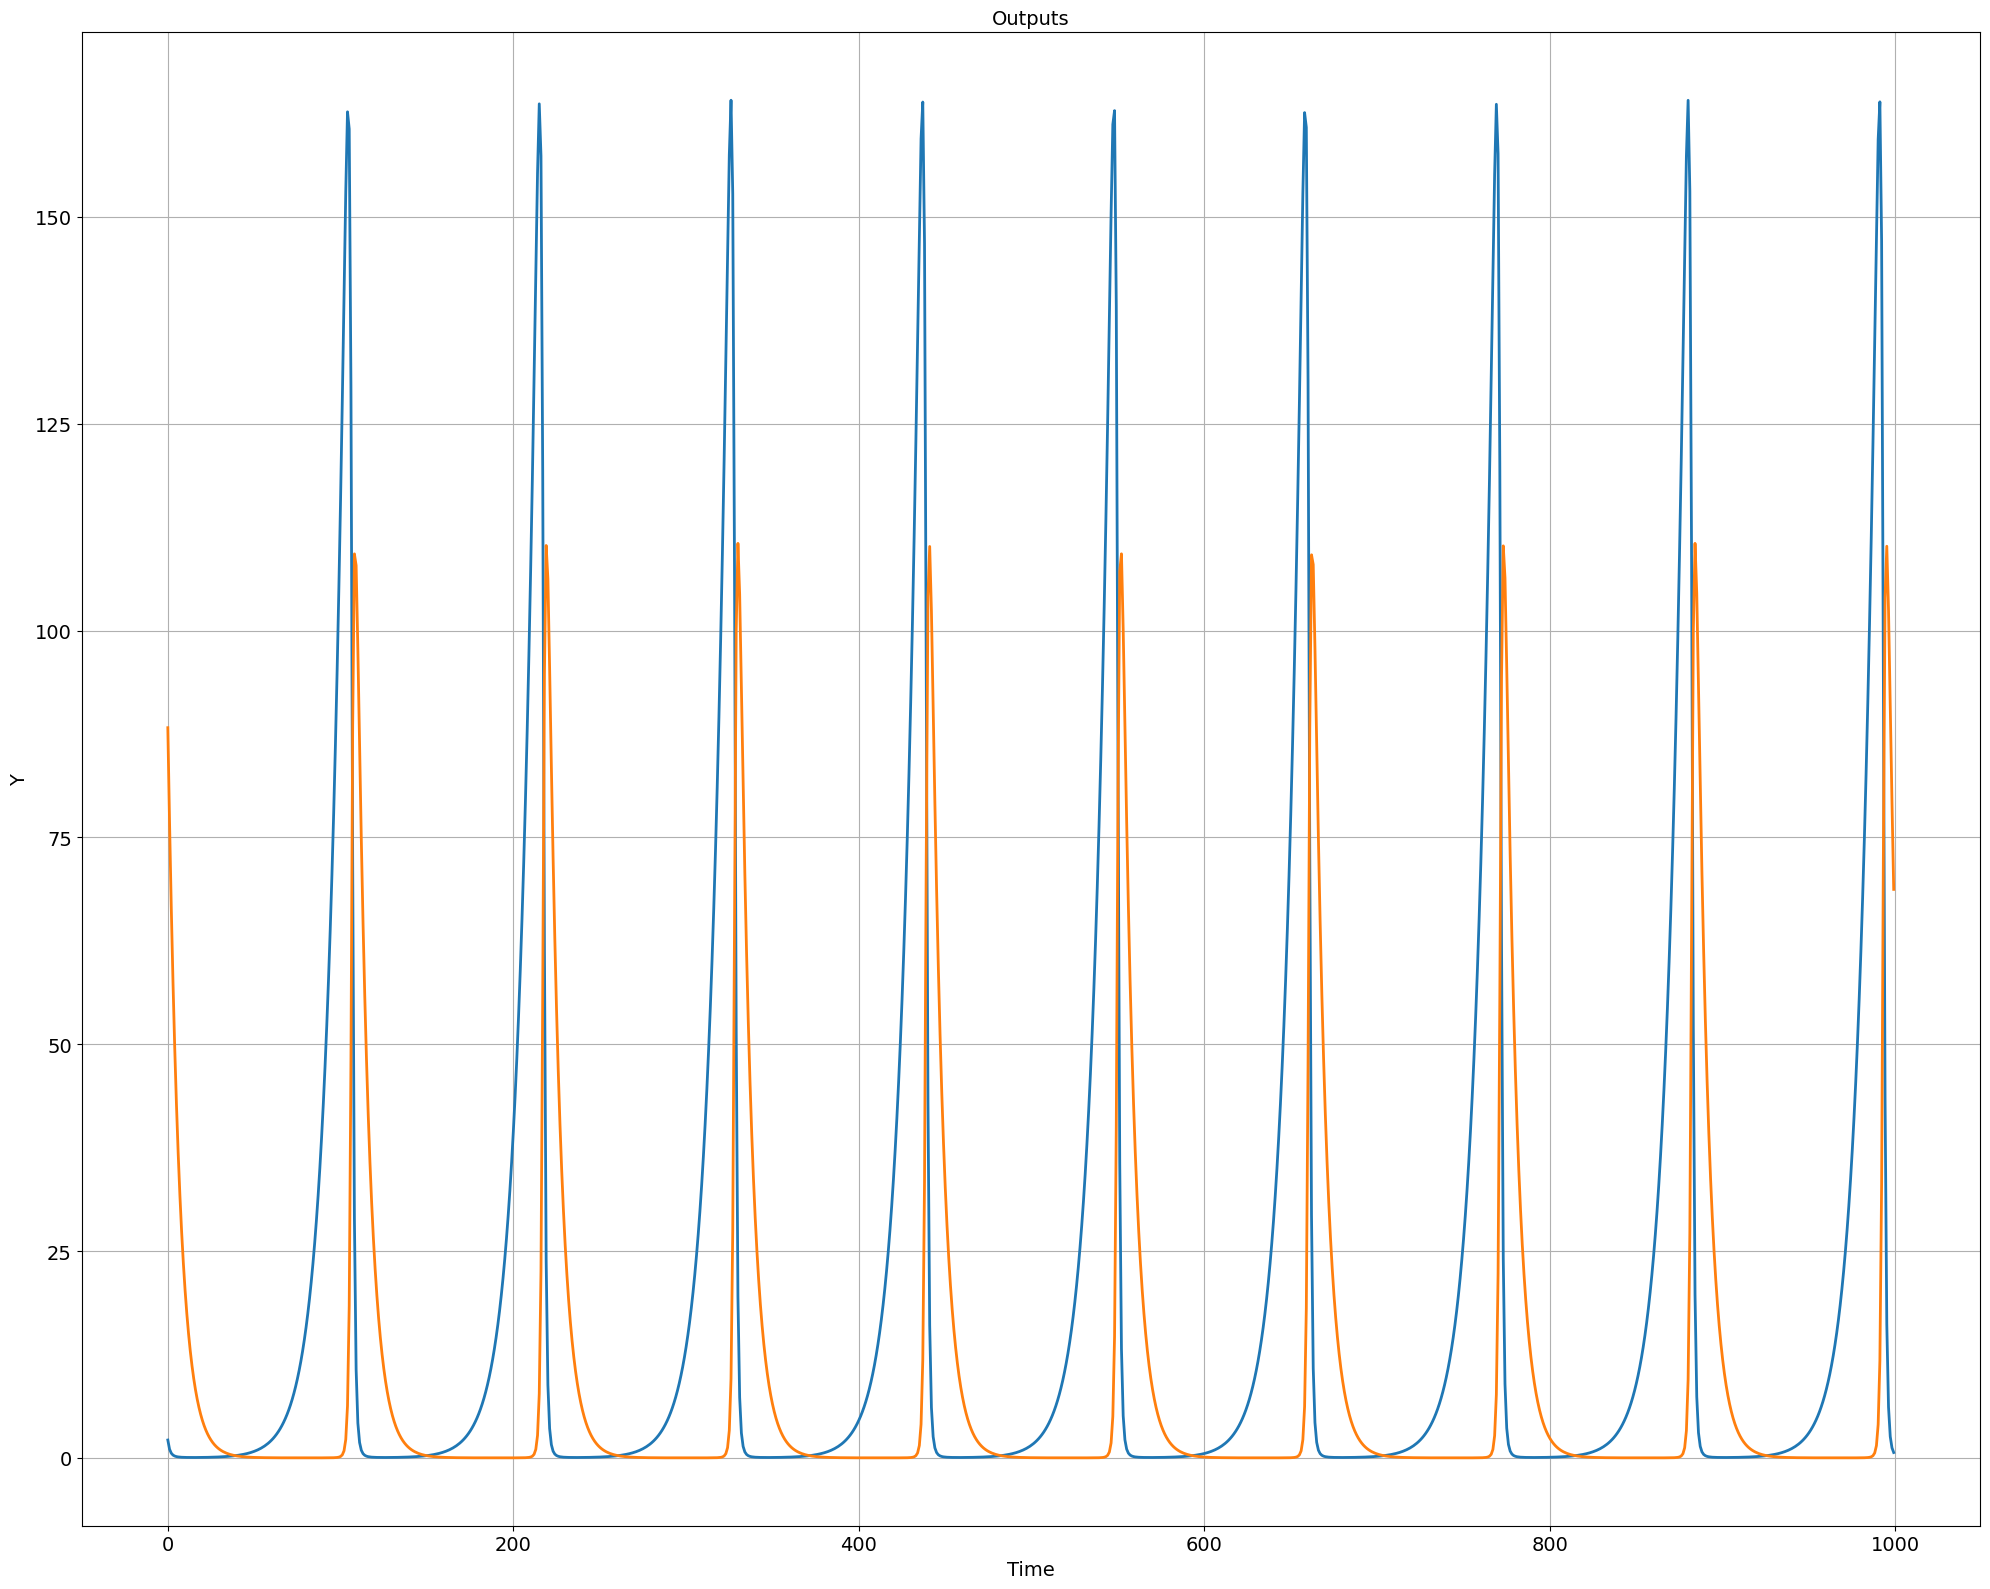

In [32]:

def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nbatch = nsim//nsteps #500
    length = (nsim//nsteps) * nsteps #1000
    ts = torch.linspace(0,1,nsteps)
    print('train sim ', train_sim['X'].shape)

    trainX = train_sim['X'][:length].reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)

    print(trainX.shape)# N x nsteps x state_size 

    train_data = DictDataset({'X': trainX, 'xn': trainX[:, 0:1, :]}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = dev_sim['X'][:length].reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'xn': devX[:, 0:1, :]}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = test_sim['X'][:length].reshape(1, nsim, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    test_data = {'X': testX, 'xn': testX[:, 0:1, :]}

    return train_loader, dev_loader, test_data, trainX

torch.manual_seed(0)

# %%  ground truth system
system = psl.systems['LotkaVolterra']
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
raw = modelSystem.simulate(nsim=1000, ts=ts)
plt.figure(figsize=(5,1))
plot.pltOL(Y=raw['X'])


We construct the NODE for the Lotka-Volterra system, creating a class inheriting from the neuromancer.ode ODESystem base class with learnable parameters

The standard Lotka-Volterra system, also known as the predator-prey model, describes the dynamics of two interacting species in a biological community. The system consists of two coupled ordinary differential equations (ODEs), typically represented as follows:

$$
\begin{align*}
\frac{dX}{dt} &= (\alpha X - \beta XY) dt  \\
\frac{dY}{dt} &= (\delta XY - \gamma Y) dt
\end{align*}
$$

In [89]:
class LotkaVolterraHybrid(ode.ODESystem):

    def __init__(self, block, insize=2, outsize=2):
        super().__init__(insize=insize, outsize=outsize)

        self.block = block
        self.alpha = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.beta = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.delta = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.gamma = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        assert self.block.in_features == 2
        assert self.block.out_features == 1

    def ode_equations(self, x):
        #Lotka Volterra equations
        x1 = x[:, [0]]
        x2 = x[:, [-1]]
        dx1 = self.alpha*x1 - self.beta*self.block(x)
        dx2 = self.delta*self.block(x) - self.gamma*x2
        return torch.cat([dx1, dx2], dim=-1)
    
    

Create the Neuromancer System to train this model:

In [90]:
nsim = 1000
nsteps = 2
bs = 10
train_loader, dev_loader, test_data, trainX = \
    get_data(modelSystem, nsim, nsteps, ts, bs)

# construct UDE model in Neuromancer
net = blocks.MLP(2, 1, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.GELU,
                    hsizes=4*[20])
fx = LotkaVolterraHybrid(net)

# integrate UDE model
fxRK4 = integrators.RK4(fx, h=ts)
# create symbolic UDE model
ude = Node(fxRK4, ['xn'], ['xn'], name='UDE')
dynamics_model = System([ude])

train sim  (1000, 2)
torch.Size([500, 2, 2])


We can train the above model using standard Neuromancer training set-up with reference and finite-difference loss functions

## 2. Neural ODEs with Added Stochasticity

We now attempt to add stochasticiity to the Neural ODE case and train likewise. We will show that this model **cannot** be trained using our standard Neural ODE training setup and thus it will necessitate a different approach -- the Latent SDE shown in section 3. 

The stochastic Lotka-Volterra system is given by:

$$
\begin{align*}
\frac{dX}{dt} &= (\alpha X - \beta XY) dt + \sigma_1 dW_1 \\
\frac{dY}{dt} &= (\delta XY - \gamma Y) dt + \sigma_2 dW_2
\end{align*}
$$

where the additional terms are the diffusion coefficients.
How can we represent this in NeuroMANCER?

### SDE Base Class

We define a base class for SDEs here (as well as in sde.py). Note that the noise_type and sde_type are hardcoded to ensure correct functionality with torchSDE. Note that the two main functions required to be implemenented are the $f$ and $g$ functions as discussed earlier. The $f$ function is equivalent to the ODESystem's `ode_equations()` but with a different signature to be compatible with torchSDE. 

In [6]:
import abc
class BaseSDESystem(abc.ABC, nn.Module):
    """
    Base class for Neural SDEs
    """
    def __init__(self):
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        self.in_features = 0
        self.out_features = 0

    @abc.abstractmethod
    def f(self, t, y):
        """
        Define the ordinary differential equations (ODEs) for the system.

        Args:
            t (Tensor): The state variables of the system.
            y (Tensor): 

        Returns:
            Tensor: The derivatives of the state variables with respect to time.
                    The output should be of shape [batch size x state size]
        """
        pass

    @abc.abstractmethod
    def g(self, t,y):
        """
        Define the diffusion equations for the system.

        Args:
            t (Tensor): The state variables of the system.
            y (Tensor): 

        Returns:
            Tensor: The diffusion coefficients per batch item (output is of size 
                    [batch size x state size]) for noise_type 'diagonal'
        """
        pass

We implement the stochastic Lotka-Volterra system with dummy parameters using this base class. We initially set the diffusion coefficients to zero to show that this simplifies to an ODE

In [8]:
class LotkaVolterraSDE(BaseSDESystem):
    def __init__(self, a, b, c, d, g_params):
        super().__init__()
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.g_params = g_params


    def f(self, t, x):
        x1 = x[:,[0]]
        x2 = x[:,[1]]
        dx1 = self.a * x1 - self.b * x1*x2
        dx2 = self.c * x1*x2 - self.d * x2
        return torch.cat([dx1, dx2], dim=-1)

    def g(self, t, x):
        return self.g_params

# Define parameters
a = 1.1    # Prey growth rate
b = 0.4   # Predation rate
c = 0.1   # Predator growth rate
d = 0.4   # Predator death rate
sigma1 = 0
sigma2 = 0
g_params = torch.tensor([[sigma1, sigma2]])
# Create the SDE model
sde = LotkaVolterraSDE(a, b, c, d, g_params)


Let's generate data from this ODE: 

In [9]:
# Define time span
import torchsde 

t_span = torch.linspace(0, 20, 2000)

# Initial condition
x0 = torch.tensor([10.0, 10.0]).unsqueeze(0) #[1x2]

# Integrate the SDE model
data = torchsde.sdeint(sde, x0, t_span, method='euler')


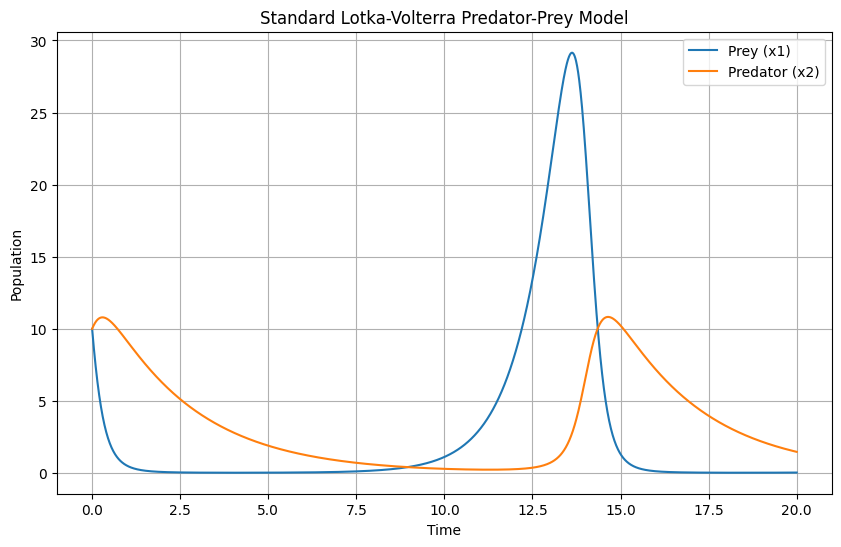

In [33]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_span, data[:, 0,0], label='Prey (x1)')
plt.plot(t_span, data[:,0, 1], label='Predator (x2)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Standard Lotka-Volterra Predator-Prey Model')
plt.legend()
plt.grid(True)
plt.show()

Now let's add some stochasticity: 

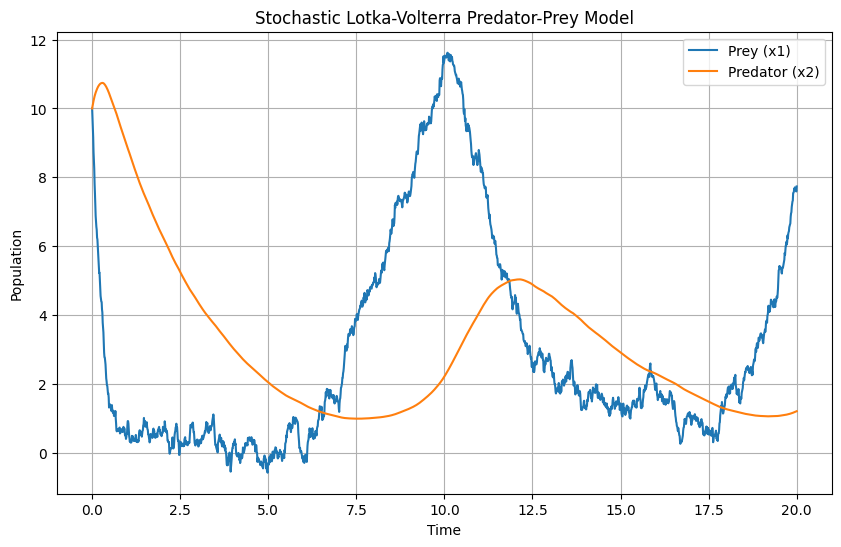

In [11]:
sigma1 = 1
sigma2 = 0
g_params = torch.tensor([[sigma1, sigma2]])
# Create the SDE model
sde = LotkaVolterraSDE(a, b, c, d, g_params)


t_span = torch.linspace(0, 20, 2000)

# Initial condition
x0 = torch.tensor([10.0, 10.0]).unsqueeze(0) #[1x2]

# Integrate the SDE model
data_stochastic = torchsde.sdeint(sde, x0, t_span, method='euler')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_span, data_stochastic[:, 0,0], label='Prey (x1)')
plt.plot(t_span, data_stochastic[:,0, 1], label='Predator (x2)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Stochastic Lotka-Volterra Predator-Prey Model')
plt.legend()
plt.grid(True)
plt.show()



#### Training a Neural SDE Using Maximal Likelihood methods (reference tracking loss)

We now show how might attempt to train a Neural SDE to fit this data using our standard Neuromancer training procedure for Neural ODEs. First we construct a Neural SDE with learnable parameters. Note that to ensure the output size condition of $g$ we pass in batch size

In [93]:
class LotkaVolterraSDELearnable(BaseSDESystem):
    def __init__(self, block, batch_size):
        super().__init__()
        self.block = block 
        self.batch_size = batch_size
        self.alpha = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.beta = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.delta = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.gamma = nn.Parameter(torch.tensor([.10]), requires_grad=True)


    def f(self, t, y):

        x1 = y[:, [0]]
        x2 = y[:, [-1]]

        dx1 = self.alpha*x1 - self.beta*self.block(y)
        dx2 = self.delta*self.block(y) - self.gamma*x2

        return torch.cat([dx1, dx2], dim=-1)
    
    def g(self, t, y):
        return torch.rand(self.batch_size, 2)

# construct UDE model in Neuromancer
net = blocks.MLP(2, 1, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.GELU,
                    hsizes=4*[20])
sde_learnable = LotkaVolterraSDELearnable(block=net, batch_size=10)
    

We transform the shape of the Lotka-Volterra stochastic dataset from earlier to have a "rollout" of 2 steps (to mimic how training is done for the Neural ODE case)

In [80]:
nx = 2
nsim = 2000
nsteps = 2
nbatch = nsim//nsteps
length = (nsim//nsteps) * nsteps
bs = 10
x_train_lvs = data_stochastic.squeeze(1)[:length].reshape(nbatch, nsteps, nx)
train_data_lvs = DictDataset({'X': x_train_lvs, 'xn': x_train_lvs[:, 0:1, :]}, name='train')
train_loader_lvs = DataLoader(train_data_lvs, batch_size=bs,
                            collate_fn=train_data_lvs.collate_fn, shuffle=True)

x_dev_lvs = data_stochastic.squeeze(1)[:length].reshape(nbatch, nsteps, nx)
dev_data_lvs = DictDataset({'X': x_dev_lvs, 'xn': x_dev_lvs[:, 0:1, :]}, name='dev')
dev_loader_lvs = DataLoader(dev_data_lvs, batch_size=bs,
                            collate_fn=dev_data_lvs.collate_fn, shuffle=True)

x_test_lvs = data_stochastic.squeeze(1)[:length].reshape(1, nsim, nx)
test_data_lvs = DictDataset({'X': x_test_lvs, 'xn': x_test_lvs[:, 0:1, :]}, name='test')
test_data_lvs_2 = {'X': x_test_lvs, 'xn': x_test_lvs[:, 0:1, :]}

We define our integrator which is a NeuroMANCER wrapper for torchSDE's sdeint. To support rollout of two time steps we give it a time step tensor of three values.

In [81]:
class BasicSDEIntegrator(integrators.Integrator): 
    """
    Integrator (from TorchSDE) for basic/explicit SDE case where drift (f) and diffusion (g) terms are defined 
    Returns a single tensor of size (t, batch_size, state_size).

    Please see https://github.com/google-research/torchsde/blob/master/torchsde/_core/sdeint.py
    Currently only supports Euler integration. Choice of integration method is dependent 
    on integral type (Ito/Stratanovich) and drift/diffusion terms
    """
    def __init__(self, block ): 
        """
        :param block: (nn.Module) The BasicSDE block
        """
        super().__init__(block) 


    def integrate(self, x): 
        """
        x is the initial datastate of size (batch_size, state_size)
        t is the time-step vector over which to integrate
        """
        t = torch.tensor([0.,0.01, 0.02], dtype=torch.float32)
        x = x.squeeze(1) #remove time step 
        ys = torchsde.sdeint(self.block, x, t, method='euler')
        ys = ys.permute(1, 0, 2)
        return ys 

We **attempt** to train the model using reference tracking and finite-difference loss workflow. Note that this model **will not** train, and this is meant to serve a motivating reason to utilize the **Latent SDE** framework.

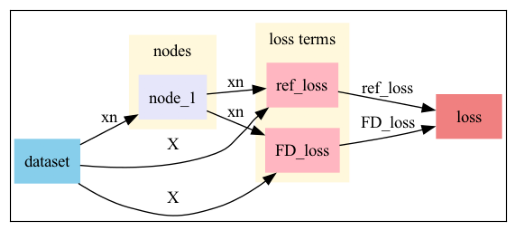

epoch: 0  train_loss: 0.022880392149090767
epoch: 1  train_loss: 0.02143489383161068
epoch: 2  train_loss: 0.021883254870772362
epoch: 3  train_loss: 0.021374505013227463
epoch: 4  train_loss: 0.021629080176353455
epoch: 5  train_loss: 0.020452190190553665
epoch: 6  train_loss: 0.02012060210108757
epoch: 7  train_loss: 0.02023428864777088
epoch: 8  train_loss: 0.019538771361112595
epoch: 9  train_loss: 0.020421745255589485
epoch: 10  train_loss: 0.020114833489060402
epoch: 11  train_loss: 0.020311430096626282
epoch: 12  train_loss: 0.01905309595167637
epoch: 13  train_loss: 0.019500289112329483
epoch: 14  train_loss: 0.019971054047346115
epoch: 15  train_loss: 0.01975109986960888
Interrupted training loop.


<All keys matched successfully>

In [94]:
integrator = BasicSDEIntegrator(sde_learnable) 
model_sde = Node(integrator, input_keys=['xn'], output_keys=['xn'])
x = variable("X")
xhat = variable('xn')[:, :-1, :]

# trajectory tracking loss
reference_loss = (xhat == x)^2
reference_loss.name = "ref_loss"

# finite difference variables
xFD = (x[:, 1:, :] - x[:, :-1, :])
xhatFD = (xhat[:, 1:, :] - xhat[:, :-1, :])


# finite difference loss
fd_loss = 2.0*((xFD == xhatFD)^2)
fd_loss.name = 'FD_loss'

# %%
objectives = [reference_loss, fd_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([model_sde], loss)
# plot computational graph
problem.show()

# %%
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)
trainer = Trainer(
    problem,
    train_loader_lvs,
    dev_loader_lvs,
    test_data_lvs_2,
    optimizer,
    patience=50,
    warmup=0,
    epochs=50,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    device='cpu', 
    epoch_verbose=1
)
# %%
best_model = trainer.train()
problem.load_state_dict(best_model)

In [95]:
with torch.no_grad(): 

    # Initial condition
    x0 = torch.ones([10,2])*10. #[1x2]
    # Integrate the SDE model
    data_stochastic_hat = torchsde.sdeint(sde_learnable, x0, t_span, method='euler')

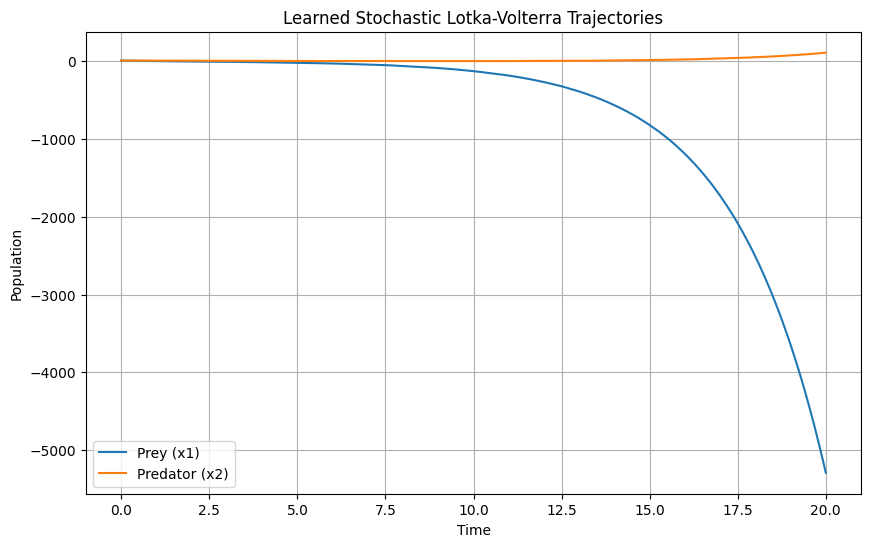

In [84]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_span, data_stochastic_hat[:, 0,0], label='Prey (x1)')
plt.plot(t_span, data_stochastic_hat[:,0, 1], label='Predator (x2)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Learned Stochastic Lotka-Volterra Trajectories')
plt.legend()
plt.grid(True)
plt.show()

It is clear using our rollout-based loss functions on observed stochastic data, similar to that in the Neural ODE case, does not work as it cannot capture the inherent randomness. Another way of putting it is the undeterministic nature of the system can cause the learned system to be unstable and blow up. Developing appropriate loss functions to ensure correctness and stability using this framework is an open research question. Thus we necessitate the need to reformulate the above procedure in a latent space and use a variational inference method to learn the stochastic data-generating distributions.

## 3. Latent SDEs

Using mean squared error (MSE) to train a neural SDE on time pairs might encounter challenges due to the stochastic nature of SDEs. While MSE is a common loss function used for deterministic systems, it may not be directly applicable to stochastic systems like SDEs. As discussed above, this is because these rollout-MSE -based losses do not capture the underlying uncertainty: 

Ignoring Stochasticity: MSE only considers the deterministic part of the model and ignores the stochastic component represented by the diffusion term in the SDE. This can lead to suboptimal results as the model does not capture the inherent randomness in the system.

Overfitting the Drift Term: MSE optimization might focus excessively on minimizing the errors in the drift term while neglecting the diffusion term. This can result in overfitting of the deterministic part of the model and underfitting of the stochastic part.

SDEs inherently involve randomness or uncertainty, typically represented by the stochastic terms in the differential equations. Instead of using refernence tracking + finite difference loss through our rollout mechanism, we can train the model using variational inference. 

#### Variaional Inference 
Variational inference allows us to capture this uncertainty by providing a probabilistic characterization of the latent variables' distribution. Instead of obtaining a single point estimate, variational inference provides a full probabilistic description, including measures of uncertainty such as confidence intervals or predictive distributions. Variational inference offers a solution to this problem by approximating the true posterior distribution with a simpler, parameterized distribution, often chosen from a family of distributions such as Gaussian distributions. This is done via an encoder network. The decoder network draws from samples of this learned, approximate posterior to reconstruct the data distribution. Using the KL divergence, between these distributions, we learn the latent space's parameters known as the variational parameters. 

The Latent SDE is essentially a variational "autoencoder" where instead of seeking resynthesize samples corresponding to the "same time" instance, it tries to reconstruct future samples given the current dynamics of the system, where the dynamics are known to be modeled via a SDE. To do this, the latent space is **itself** going to be governed via an SDE and we perform integration on the latent space to synthesize forward-looking samples. 

#### Latent SDE Architecture

We now define the architecture for the Latent SDE and train on a 3D stochastic Lorenz attractor dataset. Code adapted from https://github.com/google-research/torchsde/blob/master/examples/latent_sde_lorenz.py

1. **Encoder**:
   - The encoder maps each input data point $x$ to a distribution over latent variables $z$. This distribution is typically Gaussian with mean $\mu$ and standard deviation $\sigma$.
   $$
   q_{\phi}(z | x) = \mathcal{N}(\mu_{\phi}(x), \sigma_{\phi}(x))
   $$
   - Here, $\mu_{\phi}(x)$ and $\sigma_{\phi}(x)$ are the mean and standard deviation parameters of the Gaussian distribution, which are output by the encoder neural network parameterized by $\phi$.

2. **Latent Dynamics**:
   - The latent variables $z$ evolve over time according to a stochastic differential equation (SDE). The dynamics of $z$ are governed by drift and diffusion functions, similar to the SDE for the observed data $x$.
   $$
   dz_t = f(z_t, t) \, dt + G(z_t, t) \, dW_t
   $$
   - $f(z_t, t)$ represents the drift component, determining the deterministic evolution of the latent variables.
   - $G(z_t, t)$ represents the diffusion component, introducing stochasticity into the latent dynamics.
   - $dW_t$ is the increment of a Wiener process (Brownian motion), representing random noise.

3. **Decoder**:
   - The decoder takes samples from the latent space $z$ and maps them back to the data space $x$. It models the conditional distribution of $x$ given $z$.
   $$
   p_{\theta}(x | z)
   $$
   - The decoder neural network, parameterized by $\theta$, outputs the parameters of the conditional distribution $p_{\theta}(x | z)$, such as the mean and variance of a Gaussian distribution or the parameters of a Bernoulli distribution for binary data.

4. **Latent Variable Prior**:
   - We assume a prior distribution over the latent variables $z$. This distribution is typically chosen to be a standard Gaussian.
   $$
   p(z) = \mathcal{N}(0, I)
   $$

      though in TorchSDE's framework (and as shown in the code below), these are learnable parameters pz0_mean and pz0_logstd

5. **Objective Function**:
   - The objective function for training the Latent SDE model is similar to the ELBO in VAEs but now includes the evolution of latent variables governed by the SDE.
   $$
   \text{ELBO}(\theta, \phi; x) = \mathbb{E}_{q_{\phi}(z | x)} [\log p_{\theta}(x | z)] - \text{KL}[q_{\phi}(z | x) || p(z)]
   $$
   - The first term represents the reconstruction loss, measuring how well the decoder reconstructs the input data $x$ from the latent variable samples $z$.
   - The second term is the KL divergence between the approximate posterior $q_{\phi}(z | x)$ and the prior $p(z)$, which encourages the approximate posterior to match the prior.


### Functions to generate data from a Lorenz attractor

We define the 3D stochastic Lorenz attractor model. This model as appropriate $f$ and $g$ functions defined. To produce data samples we integrate this using the Euler-Murayama integrator from TorchSDE library

In [19]:
from neuromancer.dynamics.sde import StochasticLorenzAttractor
class StochasticLorenzAttractor(BaseSDESystem):
    def __init__(self, a: Sequence = (10., 28., 8 / 3), b: Sequence = (.1, .28, .3)):
        super(BaseSDESystem).__init__()
        self.a = a
        self.b = b

    def f(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        a1, a2, a3 = self.a

        f1 = a1 * (x2 - x1)
        f2 = a2 * x1 - x2 - x1 * x3
        f3 = x1 * x2 - a3 * x3
        return torch.cat([f1, f2, f3], dim=1)

    def g(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        b1, b2, b3 = self.b

        g1 = x1 * b1
        g2 = x2 * b2
        g3 = x3 * b3
        return torch.cat([g1, g2, g3], dim=1)
stochastic_lorenz_model = StochasticLorenzAttractor()

## Neuromancer Integration

As per the NeuroMANCER x Lightning workflow, generate the data_setup_function and return the DictDatasets. Note that we only have a train dataset here, so we return `None` for dev/test datasets

In [20]:
def make_dataset(t0, t1, batch_size, noise_std, steps=100):
    _y0 = torch.randn(batch_size, 3)
    ts = torch.linspace(t0, t1, steps=steps)
    xs = stochastic_lorenz_model.sample(_y0, ts, noise_std, normalize=True)
    train_data = DictDataset({'xs':xs},name='train')
    return train_data, None, None, batch_size
    

Define some experimental parameters

In [26]:
data_size = 3
batch_size=256
latent_size=4
context_size=64
hidden_size=128
lr_init=1e-2
t0=0.
t1=2.
lr_gamma=0.997
num_iters=1
kl_anneal_iters=1000
pause_every=50
noise_std=0.01
method="euler"
steps = 100 # number of time steps

Based on the aforementioned discussion as well as equations above for the latent SDE, we now define the model architecture consisting of a LatentSDE Encoder and Decoder. For integration in the latent space we use a LatentSDE Integrator.

In [25]:
class Encoder(nn.Module):
    """
    Encoder module to handle time-series data (as in the case of stochastic data and SDE)
    GRU is used to handle mapping to latent space in this case
    This class is used only in LatentSDE_Encoder
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)

    def forward(self, inp):
        out, _ = self.gru(inp)
        out = self.lin(out)
        return out
    
class LatentSDE_Encoder(BaseSDESystem):
    def __init__(self, data_size, latent_size, context_size, hidden_size, ts, adjoint=False):
        super(BaseSDESystem).init__()


        self.adjoint = False

        # Encoder.
        self.encoder = Encoder(input_size=latent_size, hidden_size=hidden_size, output_size=context_size)
        self.qz0_net = nn.Linear(context_size, latent_size + latent_size) #Layer to return mean and variance of the parameterized latent space

        # Decoder.
        self.f_net = nn.Sequential(
            nn.Linear(latent_size + context_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size),
        )
        self.h_net = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size),
        )
        # This needs to be an element-wise function for the SDE to satisfy diagonal noise.
        self.g_nets = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(1, hidden_size),
                    nn.Softplus(),
                    nn.Linear(hidden_size, 1),
                    nn.Sigmoid()
                )
                for _ in range(latent_size)
            ]
        )
        self.projector = nn.Linear(latent_size, data_size)

        self.pz0_mean = nn.Parameter(torch.zeros(1, latent_size))
        self.pz0_logstd = nn.Parameter(torch.zeros(1, latent_size))

        self._ctx = None
        self.ts = ts

    def contextualize(self, ctx):
        self._ctx = ctx  # A tuple of tensors of sizes (T,), (T, batch_size, d).

    def f(self, t, y):
        ts, ctx = self._ctx

        i = min(torch.searchsorted(ts, t, right=True), len(ts) - 1)

        return self.f_net(torch.cat((y, ctx[i]), dim=1))

    def h(self, t, y):
        return self.h_net(y)

    def g(self, t, y):  # Diagonal diffusion.
        y = torch.split(y, split_size_or_sections=1, dim=1)
        out = [g_net_i(y_i) for (g_net_i, y_i) in zip(self.g_nets, y)]
        return torch.cat(out, dim=1)

    def forward(self, xs):
        # Contextualization is only needed for posterior inference.
        ctx = self.encoder(torch.flip(xs, dims=(0,)))
        ctx = torch.flip(ctx, dims=(0,))
        self.contextualize((self.ts, ctx))

        qz0_mean, qz0_logstd = self.qz0_net(ctx[0]).chunk(chunks=2, dim=1)
        z0 = qz0_mean + qz0_logstd.exp() * torch.randn_like(qz0_mean)
        if not self.adjoint:
            return z0, xs, self.ts, qz0_mean, qz0_logstd
        else:
            adjoint_params = (
                    (ctx,) +
                    tuple(self.f_net.parameters()) + tuple(self.g_nets.parameters()) + tuple(self.h_net.parameters())
            )
            return z0, xs, self.ts, qz0_mean, qz0_logstd, adjoint_params

class LatentSDE_Decoder(nn.Module):
    """
    Second part of Wrapper for torchsde's Latent SDE class to integrate with Neuromancer. This takes in output of
    LatentSDEIntegrator and decodes it back into the "real" data space and also outputs associated Gaussian distributions
    to be used in the final loss function.
    Please see https://github.com/google-research/torchsde/blob/master/examples/latent_sde_lorenz.py
    """
    def __init__(self, data_size, latent_size, noise_std):
        super().__init__()
        self.noise_std = noise_std
        self.pz0_mean = nn.Parameter(torch.zeros(1, latent_size))
        self.pz0_logstd = nn.Parameter(torch.zeros(1, latent_size))
        self.projector = nn.Linear(latent_size, data_size)

    def forward(self, xs, zs, log_ratio, qz0_mean, qz0_logstd):
        _xs = self.projector(zs)
        xs_dist = Normal(loc=_xs, scale=self.noise_std)
        log_pxs = xs_dist.log_prob(xs).sum(dim=(0, 2)).mean(dim=0)

        qz0 = torch.distributions.Normal(loc=qz0_mean, scale=qz0_logstd.exp())
        pz0 = torch.distributions.Normal(loc=self.pz0_mean, scale=self.pz0_logstd.exp())
        logqp0 = torch.distributions.kl_divergence(qz0, pz0).sum(dim=1).mean(dim=0)
        logqp_path = log_ratio.sum(dim=0).mean(dim=0)
        return _xs, log_pxs, logqp0 + logqp_path, log_ratio

Define Neuromancer components, variables, and problem to train the LatentSDE. We define two nodes -- one for encoding and integrating, one for decoding. Upon training, this LatentSDE will generate new samples that exhibit the behavior of the Lorenz attractor training data. For this example, we set `adjoint` to `False` (do not use the adjoint sensitivity method). This is because this method seems to be significantly slower. 

Also note that we need to pass in the timestep tensor to our `LatentSDE_Encoder`, and as a result need to also define it outside the `make_dataset()` function. We note that this is not the cleanest code and breaks the data abstraction. Additional features will be added to mitigate this.

In [8]:
ts = torch.linspace(t0, t1, steps=steps)

sde_block_encoder = LatentSDE_Encoder(data_size, latent_size, context_size, hidden_size, ts=ts, adjoint=False) 
integrator = integrators.LatentSDEIntegrator(sde_block_encoder, adjoint=False)
model_1 = Node(integrator, input_keys=['xs'], output_keys=['zs', 'z0', 'log_ratio',  'xs', 'qz0_mean', 'qz0_logstd'], name='m1')
sde_block_decoder = blocks.LatentSDE_Decoder(3, latent_size, noise_std=noise_std)
model_2 = Node(sde_block_decoder, input_keys=['xs', 'zs', 'log_ratio', 'qz0_mean', 'qz0_logstd'], output_keys=['xs_hat', 'log_pxs', 'sum_term', 'log_ratio'], name='m2' )



log_ratio = variable('log_ratio')
log_pxs = variable('log_pxs')

# NeuroMANCER loss function format
loss = (-1.0*log_pxs + log_ratio) == 0.0

# aggregate list of objective terms and constraints
objectives = [loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([model_1, model_2], loss)

We now define helper visualization function (again see https://github.com/google-research/torchsde/blob/master/examples/latent_sde_lorenz.py) that will fire every N epochs in our training loop. This visualization will allow us to see the learned Lorenz attractor samples 

In [9]:
# Fix the same Brownian motion for visualization.
bm_vis = torchsde.BrownianInterval(
    t0=t0, t1=t1, size=(batch_size, latent_size,), device='cpu', levy_area_approximation="space-time")

# 
def vis(data_dict, problem, bm_vis, img_path, num_samples=10):
    encoder, decoder = problem.nodes[0], problem.nodes[1] #extract the encoder and decoder from our problem

    fig = plt.figure(figsize=(20, 9))
    gs = gridspec.GridSpec(1, 2)
    ax00 = fig.add_subplot(gs[0, 0], projection='3d')
    ax01 = fig.add_subplot(gs[0, 1], projection='3d')

    xs = data_dict['xs'] #pull out data sample from the DictDataset
    # Left plot: data.
    z1, z2, z3 = np.split(xs.cpu().numpy(), indices_or_sections=3, axis=-1)
    [ax00.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
    ax00.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :10, 0], marker='x')
    ax00.set_yticklabels([])
    ax00.set_xticklabels([])
    ax00.set_zticklabels([])
    ax00.set_xlabel('$z_1$', labelpad=0., fontsize=16)
    ax00.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
    ax00.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
    ax00.set_title('Data', fontsize=20)
    xlim = ax00.get_xlim()
    ylim = ax00.get_ylim()
    zlim = ax00.get_zlim()

    # Right plot: samples from learned model.
    mydata = data_dict
    output = decoder(encoder(mydata))
    xs_hat = output['xs_hat'].detach().cpu().numpy() 
    #xs = latent_sde.sample(batch_size=xs.size(1), ts=ts, bm=bm_vis).cpu().numpy()
    z1, z2, z3 = np.split(xs_hat, indices_or_sections=3, axis=-1)

    [ax01.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
    ax01.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :10, 0], marker='x')
    ax01.set_yticklabels([])
    ax01.set_xticklabels([])
    ax01.set_zticklabels([])
    ax01.set_xlabel('$z_1$', labelpad=0., fontsize=16)
    ax01.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
    ax01.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
    ax01.set_title('Samples', fontsize=20)
    ax01.set_xlim(xlim)
    ax01.set_ylim(ylim)
    ax01.set_zlim(zlim)

    plt.savefig(img_path)
    plt.close()

### Neuromancer training the problem to learn the stochastic process

We now train and visualize results using Lightning workflow

In [ ]:

# Fix the same Brownian motion for visualization.
bm_vis = torchsde.BrownianInterval(
    t0=t0, t1=t1, size=(batch_size, latent_size,), device='cpu', levy_area_approximation="space-time")

# Define the custom_training_step to support visualization. 
def custom_training_step(model, batch): 
    output = model.problem(batch)
    loss = output[model.train_metric]
    img_path = os.path.join('', f'current_epoch_{model.current_epoch:06d}.pdf')
    if model.current_epoch % 50 == 0: 
        vis(batch,  model.problem, bm_vis, img_path, num_samples=10)
    return loss


optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)
lit_trainer = LitTrainer(epochs=300, accelerator='cpu', train_metric='train_loss', 
                         dev_metric='train_loss', eval_metric='train_loss', test_metric='train_loss',
                         custom_optimizer=optimizer, custom_training_step=custom_training_step)



lit_trainer.fit(problem=problem, data_setup_function=make_dataset,  t0=t0, t1=t1, batch_size=batch_size, noise_std=noise_std)
